1. Replaced values in the 'is_recommended' column, where True was replaced with 1 and False with -1.

2. Filtered out the 30,000 users for recommendation data.

3. Binned the 'helpful' column to create the 'helpful_score' column using the following criteria:
- If helpful = 0, helpful_score = 1
- If helpful < 25th percentile of 'helpful' data, helpful_score = 2
- If helpful is between the 25th and 50th percentiles, helpful_score = 3
- If helpful is between the 50th and 75th percentiles, helpful_score = 4
- If helpful is above the 75th percentile, helpful_score = 5

4. Transformed the 'hours' column using the logarithm function to create the 'hours_log' column.

5. Calculated the 'date_factor' of the date column, assigning higher values to dates closer to the latest date of recommendation and vice versa.

6. Multiplied the 'helpful_score', 'hours_log', and 'date_factor' columns to obtain the 'recommendation_credibility' column.
7. Normalized the 'recommendation_credibility' column to obtain 'recommendation_credibility_normalized', with values ranging from 0 to 1.

8. Transformed the 'recommendation_credibility_normalized' column using the logarithm function to create the 'recommendation_credibility_normalized_log' column.






## The output of the code below will have
'app_id' : unique game id

'helpful' : whether the other users think the recommendation is helpful

'funny' : whether the other users think the recommendation is funny

'date' : date of recommendation made

'is_recommended' : user recommend the game or not

'hours' : the number of hours the user played the game

'user_id' : unique user id

'review_id' : unique identifier of each row

'helpful_score' : Value from 1 to 5. Score of whether the other users think the recommendation is helpful

'hours_log': log hours

'score' : Calculate the date_factor based on the difference in years (not useful)

'date_factor' : The nearer the date of recommendation made to current date, the higher the date_factor. For example, recommendation made on 2022 will have higher date_factor than recommendation made on 2010.

'recommendation_credibility' : Multiplied 'helpful_score', 'hours_log' and 'date_factor'

'recommendation_credibility_normalized' : Normalised 'recommendation_credibility' which have value between 0 and 1

'recommendation_credibility_normalized_log': log 'recommendation_credibility_normalized'. This will be the recommendation score to be used.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/Data

/content/drive/.shortcut-targets-by-id/1ULLLy85cSk9PIcDP9L47wxLxA2Loq2AX/Data


In [ ]:
data = pd.read_csv('recommendations.csv')

In [ ]:
user = pd.read_csv('sample_user_data.csv')

In [ ]:
user.head()

,user_id,products,reviews,average_recommendation_credibility,reviews_scaled,products_scaled,average_recommendation_credibility_scaled,user_credibility,user_credibility_log
0,947,216.0,12.0,0.000000,0.004924,0.007260,0.000000,0.004381,0.004372
1,1107,242.0,9.0,0.000000,0.003693,0.008134,0.000000,0.004361,0.004352
2,1345,149.0,9.0,0.000000,0.003693,0.005008,0.000000,0.003111,0.003106
3,1405,580.0,23.0,0.059939,0.009438,0.019494,0.108541,0.043191,0.042285
4,1634,168.0,23.0,0.000000,0.009438,0.005647,0.000000,0.005090,0.005077


In [ ]:
data.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,51580,0
1,304390,4,0,2017-02-17,False,11.5,2586,1
2,1085660,2,0,2019-11-17,True,336.5,253880,2
3,703080,0,0,2022-09-23,True,27.4,259432,3
4,526870,0,0,2021-01-10,True,7.9,23869,4


In [ ]:
# List of user_ids existing in 'user' DataFrame
existing_user_ids = user['user_id'].tolist()

# Filtering out rows in 'data' DataFrame where 'user_id' exists in 'existing_user_ids'
filtered_data = data[data['user_id'].isin(existing_user_ids)]


In [ ]:
filtered_data.shape

(531429, 8)

In [ ]:
# Extracting the 'user_id' column from the 'filtered_data' DataFrame and converting it to a list
existing_user_ids = set(filtered_data['user_id'].tolist())

# Getting the count of unique user_ids after filtering
len(existing_user_ids)


30000

In [ ]:
data = filtered_data.copy()

In [ ]:
# Replace 'True' with 1 and 'False' with -1 in the 'is_recommend' column
data['is_recommended'] = data['is_recommended'].replace({True: 1, False: -1})

In [ ]:
# Filtering out rows in 'data' DataFrame where 'helpful' is not equal to 0
non_zero_helpful = data[data['helpful'] != 0]

# Calculating quantiles of 'helpful' column for categorization
quantiles = non_zero_helpful['helpful'].quantile([0.25, 0.5, 0.75])

# Creating a new column 'helpful_score' based on 'helpful' values
data['helpful_score'] = non_zero_helpful['helpful'].apply(lambda x: 1 if x == 0 else (2 if x <= quantiles.iloc[0] else (3 if x <= quantiles.iloc[1] else (4 if x <= quantiles.iloc[2] else 5))))

# Filling missing values in 'helpful_score' column with 1
data['helpful_score'].fillna(1, inplace=True)

# Displaying 'helpful' and 'helpful_score' columns
print(data[['helpful', 'helpful_score']])


          helpful  helpful_score
253             0            1.0
268             2            2.0
510             0            1.0
868             4            3.0
1172            0            1.0
...           ...            ...
41154626        0            1.0
41154664        0            1.0
41154679        0            1.0
41154691        0            1.0
41154699        0            1.0

[531429 rows x 2 columns]


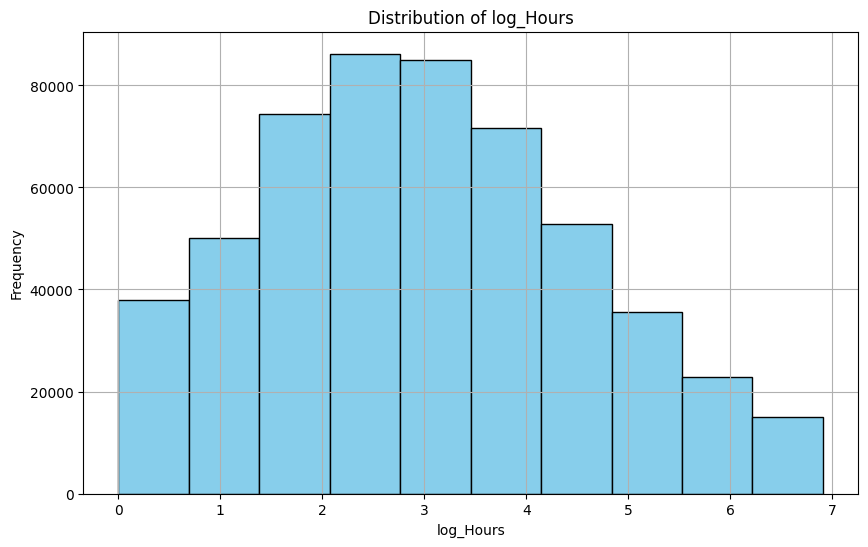

In [ ]:
# Calculating the logarithm of 'hours' column and adding 1 to handle zero values
data['hours_log'] = np.log(data['hours'] + 1)

# Plotting the histogram of 'hours_log'
plt.figure(figsize=(10, 6))
data['hours_log'].hist(bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of log_Hours')
plt.xlabel('log_Hours')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Importing datetime module
from datetime import datetime

# Define weights for each factor
# We put the lowest weight for weight_helpful as we realized the data is skewed even after preprocessing,
# thus we decided to give it less weight
weight_helpful = 0.2
weight_hours = 0.4
weight_date = 0.4

# Converting 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Finding the maximum date in the dataframe and adding 1 year
max_date = data['date'].max() + pd.Timedelta(days=365)

# Calculating the date factor based on the difference in years
data['score'] = max_date.year - data['date'].dt.year

# Calculating the date factor
data['date_factor'] = data['score'].apply(lambda x: 1 / (1 + x))

# Scaling up the date factor values to a larger range
max_date_factor = data['date_factor'].max()

# Calculating recommendation credibility
data['recommendation_credibility'] = ((data['helpful_score'] * weight_helpful) *
                                      (data['hours_log'] * weight_hours) *
                                      (data['date_factor'] * weight_date))

# Optionally, normalize the credibility scores to a scale of 0 to 1
max_credibility_score = data['recommendation_credibility'].max()
data['recommendation_credibility_normalized'] = round(data['recommendation_credibility'] / max_credibility_score, 5)

# Displaying the dataframe with the calculated credibility
print(data)



           app_id  helpful  funny       date  is_recommended  hours  user_id  \
253       1419170        0      0 2021-08-13               1    0.4  3305939   
268        239030        2      0 2019-01-08               1   34.4  5755947   
510        311210        0      0 2021-08-03               1  104.3  2323347   
868           570        4      0 2013-12-16               1  893.0  4572014   
1172      1284210        0      0 2022-09-04               1    0.4  7273338   
...           ...      ...    ...        ...             ...    ...      ...   
41154626   253430        0      0 2015-07-12              -1    1.0  2444255   
41154664   391220        0      0 2020-09-12               1   72.0  9205268   
41154679   391220        0      0 2020-08-21               1   64.0  1753363   
41154691   262060        0      0 2019-11-04               1   75.0  5035865   
41154699      400        0      0 2020-07-12               1   10.0  4216548   

          review_id  helpful_score  hou

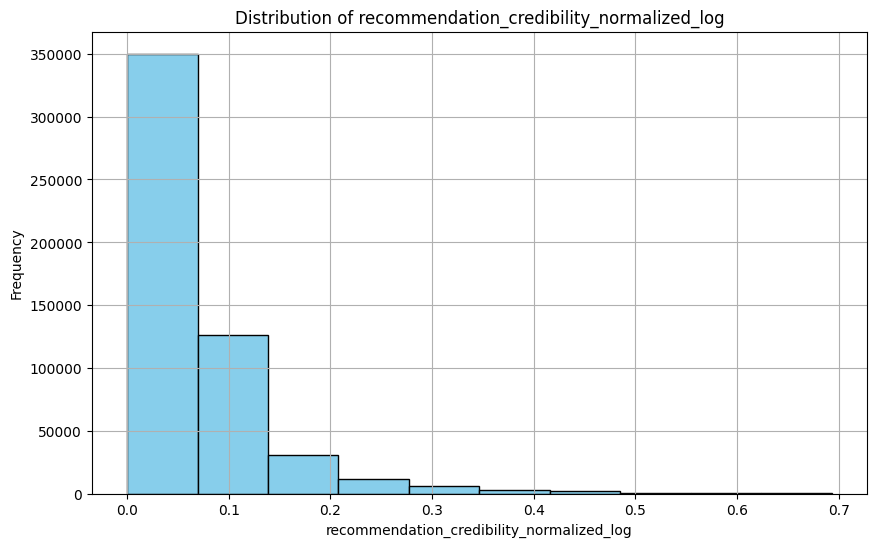

In [ ]:
# Calculating the logarithm of 'recommendation_credibility_normalized' column and adding 1 to handle zero values
data['recommendation_credibility_normalized_log'] = np.log(data['recommendation_credibility_normalized'] + 1)

# Plotting the histogram of 'recommendation_credibility_normalized_log'
plt.figure(figsize=(10, 6))
data['recommendation_credibility_normalized_log'].hist(bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of recommendation_credibility_normalized_log')
plt.xlabel('recommendation_credibility_normalized_log')
plt.ylabel('Frequency')
plt.show()


In [ ]:
data

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id,helpful_score,hours_log,score,date_factor,recommendation_credibility,recommendation_credibility_normalized,recommendation_credibility_normalized_log
253,1419170,0,0,2021-08-13,1,0.4,3305939,253,1.0,0.336472,2,0.333333,0.003589,0.00650,0.006479
268,239030,2,0,2019-01-08,1,34.4,5755947,268,2.0,3.566712,4,0.200000,0.045654,0.08267,0.079430
510,311210,0,0,2021-08-03,1,104.3,2323347,510,1.0,4.656813,2,0.333333,0.049673,0.08995,0.086132
868,570,4,0,2013-12-16,1,893.0,4572014,868,3.0,6.795706,10,0.090909,0.059308,0.10740,0.102015
1172,1284210,0,0,2022-09-04,1,0.4,7273338,1172,1.0,0.336472,1,0.500000,0.005384,0.00975,0.009703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41154626,253430,0,0,2015-07-12,-1,1.0,2444255,41154626,1.0,0.693147,8,0.111111,0.002465,0.00446,0.004450
41154664,391220,0,0,2020-09-12,1,72.0,9205268,41154664,1.0,4.290459,3,0.250000,0.034324,0.06216,0.060305
41154679,391220,0,0,2020-08-21,1,64.0,1753363,41154679,1.0,4.174387,3,0.250000,0.033395,0.06048,0.058722
41154691,262060,0,0,2019-11-04,1,75.0,5035865,41154691,1.0,4.330733,4,0.200000,0.027717,0.05019,0.048971


In [ ]:
# Saving the DataFrame to a CSV file named 'recommendations_with_score.csv'
data.to_csv('recommendations_with_score.csv', index=False)



The following code primarily involves exploratory data analysis (EDA) and testing various methods. However, due to the large dataset and limited available RAM, the code has been commented out.

In [ ]:
# data2 = pd.read_csv('recommendations_with_score.csv')


In [ ]:
# data2.shape

(531429, 15)

In [ ]:
# data = data.sort_values(by='user_id', ascending = True)
# data.head(15)

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id,helpful_score,hours_log,score,date_factor,recommendation_credibility,recommendation_credibility_normalized,recommendation_credibility_normalized_log
8967417,1036890,0,2,2022-03-04,1,6.2,947,8967417,1.0,1.974081,1,0.500000,0.031585,0.05720,0.055624
2933059,782330,2,0,2020-11-30,1,73.8,947,2933059,2.0,4.314818,3,0.250000,0.069037,0.12502,0.117801
16821258,964800,12,4,2022-09-27,-1,11.2,947,16821258,5.0,2.501436,1,0.500000,0.200115,0.36239,0.309241
11373973,809020,0,0,2019-06-29,1,8.3,947,11373973,1.0,2.230014,4,0.200000,0.014272,0.02585,0.025522
30897590,716490,14,0,2018-11-25,1,50.4,947,30897590,5.0,3.939638,5,0.166667,0.105057,0.19025,0.174163
37243937,312990,5,0,2017-07-20,1,1.0,947,37243937,4.0,0.693147,6,0.142857,0.012675,0.02295,0.022691
16343859,519860,25,0,2021-03-17,1,19.4,947,16343859,5.0,3.015535,2,0.333333,0.160829,0.29124,0.255603
2543284,292030,0,0,2021-02-15,1,79.2,947,2543284,1.0,4.384524,2,0.333333,0.046768,0.08469,0.081294
17079476,1511780,9,0,2022-07-05,1,43.6,947,17079476,4.0,3.797734,1,0.500000,0.243055,0.44015,0.364747
13723870,268910,2,0,2017-11-25,1,48.7,947,13723870,2.0,3.906005,6,0.142857,0.035712,0.06467,0.062665


In [ ]:
# data.shape

(531429, 15)

In [ ]:
# data

In [ ]:
# # Check null values
# null_columns = data.isnull().any()

# print(null_columns)

# # Check na values
# na_columns = data.isna().any()

# print(na_columns)

In [ ]:


# data['date'] = pd.to_datetime(data['date'])

# # # Plot the distribution of dates
# # plt.figure(figsize=(10, 6))
# # data['date'].hist(bins=10, color='skyblue', edgecolor='black')
# # plt.title('Distribution of Dates')
# # plt.xlabel('Date')
# # plt.ylabel('Frequency')
# # plt.show()

In [ ]:
# # Looking at the distribution of date of recommendation in year

# data['year'] = data['date'].dt.year

# # Plot the distribution of dates by year
# plt.figure(figsize=(10, 6))
# data['year'].hist(bins=len(data['year'].unique()), color='skyblue', edgecolor='black')
# plt.title('Distribution of Dates by Year')
# plt.xlabel('Year')
# plt.ylabel('Frequency')
# plt.show()

In [ ]:
# # Correlation matrix
# import seaborn as sns

# correlation_matrix = data[['helpful', 'hours']].corr()

# # Plot the correlation matrix heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
# plt.title('Correlation Matrix Heatmap')
# plt.show()

In [ ]:
# plt.figure(figsize=(10, 6))
# sns.histplot(data['helpful'], bins=20, kde=True)
# plt.title('Distribution of Helpful')
# plt.xlabel('Helpful')
# plt.ylabel('Frequency')
# plt.show()

In [ ]:
# data['helpful'].value_counts().sort_index()

In [ ]:
# print("Mean:", data['helpful'].mean())
# print("Median:", data['helpful'].median())
# print("Standard Deviation:", data['helpful'].std())

In [ ]:
# zero_count = data['helpful'].value_counts().get(0, 0)

# percentage_zero_count = zero_count/len(data)

# percentage_zero_count

In [ ]:
# plt.figure(figsize=(8, 6))
# sns.boxplot(x=data['helpful'])
# plt.title('Boxplot of Helpful')
# plt.xlabel('Helpful')
# plt.show()

The column 'helpful' have 32461479 rows which is around 79% of the data with value '0'. I decided to bin them based on every 10% of the data with scale 1 to 10.

Besides, there are data that have very big value such as 35000 as shown in the boxplot above. I did not remove it as I think there will be loss of information if it is removed.

This is StandardScaler and MinMaxScaler

In [ ]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# import numpy as np

# # Sample data
# helpful_data = data['helpful'].values.reshape(-1, 1)
# hours_data = data['hours'].values.reshape(-1, 1)

# # Concatenate both columns into a single array
# combined_data = np.concatenate((helpful_data, hours_data), axis=1)

# # Create instances of StandardScaler
# scaler_standard = StandardScaler()

# # Fit and transform the combined data
# scaled_combined_standard = scaler_standard.fit_transform(combined_data)

# # Create instances of MinMaxScaler
# scaler_minmax = MinMaxScaler()

# # Fit and transform the combined data
# scaled_combined_minmax = scaler_minmax.fit_transform(scaled_combined_standard)

# # # Separate the scaled data back into individual columns
# # scaled_helpful_standard = scaled_combined_standard[:, 0].reshape(-1, 1)
# # scaled_hours_standard = scaled_combined_standard[:, 1].reshape(-1, 1)

# # scaled_helpful_minmax = scaled_combined_minmax[:, 0].reshape(-1, 1)
# # scaled_hours_minmax = scaled_combined_minmax[:, 1].reshape(-1, 1)


In [ ]:
# data['helpful'].hist()
# pyplot.show()

In [ ]:
# from matplotlib import pyplot
# dataset = pd.DataFrame(scaled_combined_minmax)
# print(dataset.describe())
# # histograms of the variables
# dataset.hist()
# pyplot.show()

This is StandardScaler, MinMaxScaler but it is not mixed together

In [ ]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

# # Sample data
# helpful_data = data['helpful'].values.reshape(-1, 1)
# hours_data = data['hours'].values.reshape(-1, 1)

# # Create instances of StandardScaler
# scaler_helpful = StandardScaler()
# scaler_hours = StandardScaler()

# # Fit and transform the data for 'helpful'
# scaled_helpful_standard = scaler_helpful.fit_transform(helpful_data)

# # Fit and transform the data for 'hours'
# scaled_hours_standard = scaler_hours.fit_transform(hours_data)

# # Create instances of MinMaxScaler
# min_max_scaler_helpful = MinMaxScaler()
# min_max_scaler_hours = MinMaxScaler()

# # Fit and transform the data for 'helpful'
# scaled_helpful_minmax = min_max_scaler_helpful.fit_transform(helpful_data)

# # Fit and transform the data for 'hours'
# scaled_hours_minmax = min_max_scaler_hours.fit_transform(hours_data)


In [ ]:
# log_scaled_helpful_minmax = np.log(scaled_combined_minmax[:, 0].reshape(-1, 1))


In [ ]:
# import numpy as np

# # Add a small constant to avoid taking the logarithm of zero or negative values
# small_constant = 1e-6  # You can adjust this value based on your data

# # Log-transform the scaled data for 'helpful' with added small constant
# log_scaled_helpful_minmax = np.log(log_scaled_helpful_minmax + small_constant)


In [ ]:
# import matplotlib.pyplot as plt

# # Plot histogram of log-transformed scaled helpful data
# # plt.hist(log_scaled_helpful_minmax, bins=20, edgecolor='black')
# # plt.title('Histogram of Log-Transformed Scaled Helpful Data')
# # plt.xlabel('Log-Transformed Scaled Helpful Data')
# # plt.ylabel('Frequency')
# # plt.grid(True)
# # plt.show()
# # Define grid of plots
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# scaled_helful_minmax = pd.DataFrame(scaled_combined_minmax[:, 0].reshape(-1, 1))

# axs[0].hist(scaled_helful_minmax, edgecolor='black')
# axs[1].hist(log_scaled_helpful_minmax, edgecolor='black')

# #add title to each histogram
# axs[0].set_title('Original Data')
# axs[1].set_title('Log-Transformed Scaled Helpful Data')

This is not used anymore

In [ ]:
# import matplotlib.pyplot as plt

# # Define grid of plots
# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# # Create histograms for 'helpful' (StandardScaler)
# axs[0, 0].hist(scaled_helpful_standard, edgecolor='black')
# axs[0, 0].set_title('StandardScaler - Helpful')

# # Create histograms for 'hours' (StandardScaler)
# axs[0, 1].hist(scaled_hours_standard, edgecolor='black')
# axs[0, 1].set_title('StandardScaler - Hours')

# # Create histograms for 'helpful' (MinMaxScaler)
# axs[1, 0].hist(scaled_helpful_minmax, edgecolor='black')
# axs[1, 0].set_title('MinMaxScaler - Helpful')

# # Create histograms for 'hours' (MinMaxScaler)
# axs[1, 1].hist(scaled_hours_minmax, edgecolor='black')
# axs[1, 1].set_title('MinMaxScaler - Hours')

# # Set common xlabel
# for ax_row in axs:
#     for ax in ax_row:
#         ax.set_xlabel('Value')

# # Set common ylabel
# for ax in axs[:, 0]:
#     ax.set_ylabel('Frequency')

# # Show the plots
# plt.tight_layout()
# plt.show()


In [ ]:
# log_scaled_helpful_minmax = log(scaled_helpful_minmax)

Helpful score
i forced the 'helpful' column by binning it...like
helpful = 0, helpful_score = 1,
helpful < 25% of data['helpful'], helpful_score = 2,
25% < helpful < 50%, helpful_score = 3,
50% < helpful < 75%, helpful_score = 4,
75% < helpful < 100%, helpful_score = 5

In [ ]:
# def calculate_helpful_score(x):
#     if x == 0:
#         return 1
#     elif 1 <= x <= 10:
#         return 2
#     elif x > 10 and x <= 1000:
#         return np.log(x)  # Apply logarithmic scaling for values between 10 and 100
#     else:
#         return 10  # Assign a fixed value for large extreme values

# # Step 2: Apply the custom function to compute credibility scores
# data['helpful_score'] = data['helpful'].apply(calculate_helpful_score)

# # Display the DataFrame with credibility scores
# print(data[['helpful', 'helpful_score']])

In [ ]:
# plt.figure(figsize=(10, 6))
# data['helpful_score'].hist(bins=10, color='skyblue', edgecolor='black')
# plt.title('Distribution of Helpful')
# plt.xlabel('Helpful')
# plt.ylabel('Frequency')
# plt.show()

In [ ]:
# data['helpful_score'].value_counts()

In [ ]:
# plt.figure(figsize=(10, 6))
# data['helpful_score'].hist(bins=10, color='skyblue', edgecolor='black')
# plt.title('Distribution of Helpful')
# plt.xlabel('Helpful')
# plt.ylabel('Frequency')
# plt.show()

In [ ]:
# data['helpful_score_log'] = np.log(data['helpful_score'])  # Adding 1 to handle zero values


In [ ]:
# plt.figure(figsize=(10, 6))
# data['helpful_score_log'].hist(bins=10, color='skyblue', edgecolor='black')
# plt.title('Distribution of Helpful')
# plt.xlabel('Helpful')
# plt.ylabel('Frequency')
# plt.show()

I tried log, sqrt, and cube root to make the distribution more normal

In [ ]:
# data['helpful_log'] = np.log(data['helpful']+1)  # Adding 1 to handle zero values

In [ ]:
# data['helpful_log'].value_counts()

In [ ]:
# fig, axs = plt.subplots(nrows=1, ncols=2)

# #create histograms
# axs[0].hist(data['helpful'], edgecolor='black')
# axs[1].hist(data['helpful_log'], edgecolor='black')

# #add title to each histogram
# axs[0].set_title('Original Data')
# axs[1].set_title('Log-Transformed Data')

In [ ]:
# #create log-transformed data
# data['helpful_sqrt'] = np.sqrt(data['helpful'])

# #define grid of plots
# fig, axs = plt.subplots(nrows=1, ncols=2)

# #create histograms
# axs[0].hist(data['helpful'], edgecolor='black')
# axs[1].hist(data['helpful_sqrt'], edgecolor='black')

# #add title to each histogram
# axs[0].set_title('Original Data')
# axs[1].set_title('Square Root Transformed Data')

In [ ]:
# data_log = np.cbrt(data['helpful'])

# #define grid of plots
# fig, axs = plt.subplots(nrows=1, ncols=2)

# #create histograms
# axs[0].hist(data['helpful'], edgecolor='black')
# axs[1].hist(data_log, edgecolor='black')

# #add title to each histogram
# axs[0].set_title('Original Data')
# axs[1].set_title('Cube Root Transformed Data')

In [ ]:
# import pandas as pd

# # Determine the bin edges based on every 10% of the data
# bin_edges = [0] + sorted(data['helpful'].quantile(i / 10) for i in range(1, 11))
# print(bin_edges)
# # Remove duplicate bin edges
# # bin_edges = sorted(set(bin_edges))
# # print(bin_edges)
# # # Define the bin labels (scale 1 to 10)
# # bin_labels = range(1, 11)

# # # Ensure the number of bin labels matches the number of intervals (one fewer than the number of bin edges)
# # assert len(bin_labels) == len(bin_edges) - 1, "Number of bin labels must be one fewer than the number of bin edges"

# # # Bin the 'helpful' column
# # data['helpful_binned'] = pd.cut(data['helpful'], bins=bin_edges, labels=bin_labels)

# # # Convert bin labels to integer type
# # data['helpful_binned'] = data['helpful_binned'].astype(int)

# # # Now, the 'helpful' column is binned into intervals of scale 1 to 10 based on every 10% of the data


In [ ]:
# # Filter out rows where 'helpful' is not equal to zero
# non_zero_helpful = data[data['helpful'] != 0]

# # Compute quantiles for every 10% interval
# quantiles = [non_zero_helpful['helpful'].quantile(i / 10) for i in range(1, 11)]

# # Print quantiles
# for i, quantile in enumerate(quantiles, start=1):
#     print(f'Quantile {i} (10% interval): {quantile}')

In [ ]:
# # Count values larger than 22 in the 'helpful' column
# count_larger_than_22 = (data['helpful'] > 22).sum()

# print("Number of values larger than 22 in the 'helpful' column:", count_larger_than_22)


In [ ]:
# data

In [ ]:
# data['helpful'] = data['helpful'].replace(0, 1)

In [ ]:
# sns.countplot(x='is_recommended', data=data)
# plt.title('Distribution of Recommended')
# plt.show()

In [ ]:
# data['is_recommended'].value_counts()

In [ ]:
# plt.figure(figsize=(10, 6))
# data['hours'].hist(bins=10, color='skyblue', edgecolor='black')
# plt.title('Distribution of Hours')
# plt.xlabel('Hours')
# plt.ylabel('Frequency')
# plt.show()

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# # Create an instance of MinMaxScaler
# min_max_scaler_hours = MinMaxScaler()

# # Fit and transform the 'hours' data
# scaled_hours_minmax = min_max_scaler_hours.fit_transform(data['hours'].values.reshape(-1, 1))

# # Replace the original 'hours' column with the scaled values
# data['hours_scaled'] = scaled_hours_minmax


In [ ]:
# data.to_excel('recommendations_with_score.xlsx', index=False)


In [ ]:
# data

In [ ]:
# data['recommendation_credibility_normalized'].value_counts().sort_index()

In [ ]:
# import matplotlib.pyplot as plt

# # Filter out 0 values from the 'helpful' column
# non_zero_helpful = data[data['recommendation_credibility_normalized'] != 0]

# # Plot histogram of the non-zero values
# plt.hist(non_zero_helpful, bins=20, edgecolor='black')
# plt.title('Histogram of Helpful Data (Excluding 0)')
# plt.xlabel('Helpful Data')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()

In [ ]:
# plt.figure(figsize=(10, 6))
# data['recommendation_credibility_normalized'].hist(bins=10, color='skyblue', edgecolor='black')
# plt.title('Distribution of recommendation_credibility_normalized')
# plt.xlabel('recommendation_credibility_normalized')
# plt.ylabel('Frequency')
# plt.show()

In [ ]:
# data['recommendation_credibility_normalized_log'].value_counts().sort_index()
